##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import pickle
import gensim.downloader as api
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#nltk.download('all')
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

In [55]:
usersPath = '../Data'
usersDict = {}
for user in os.listdir(usersPath):
    df = pd.read_pickle(usersPath+'/'+user+'/search.pkl')
    df['user'] = user
    usersDict[user] = df

In [56]:
combinedDF = pd.concat(usersDict.values(),ignore_index=True)
combinedDF.head()

,Search,Day,Month,Year,Time,user
0,"[find, arg, reddit]",9,10,2021,10:31:16,user0
1,[windows],1,10,2021,16:21:12,user0
2,[dropbox],2,10,2021,16:19:23,user0
3,"[increase, max, brightness, dell]",2,10,2021,16:16:51,user0
4,[youtube],2,10,2021,16:06:21,user0


C:\Users\Josh\AppData\Local\Temp/ipykernel_8468/1839368803.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(combinedDF['user'].unique(), rotation=45)


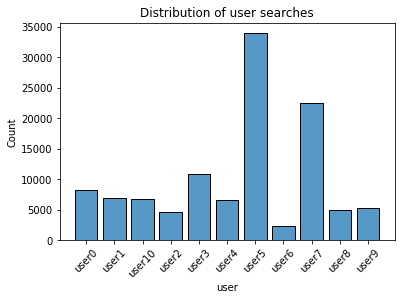

In [57]:
plot = sns.histplot(data=combinedDF, x='user', shrink=.8)
plot.set_title('Distribution of user searches')
plot.set_xticklabels(combinedDF['user'].unique(), rotation=45)
plt.show()

In [66]:
# drop user6, user2, user8, user9
combinedDF = combinedDF[~combinedDF['user'].isin(['user6','user2','user8','user9'])]

In [58]:
combinedDF.drop(combinedDF[combinedDF['Day']>31].index,inplace=True)
combinedDF.drop(combinedDF[combinedDF['Day']<0].index,inplace=True)
combinedDF.drop(combinedDF[combinedDF['Month']>12].index,inplace=True)
combinedDF.drop(combinedDF[combinedDF['Year']>2021].index,inplace=True)
combinedDF.drop(combinedDF[combinedDF['Year']<2020].index,inplace=True)

##### Downsampling
>- As we can see there are way more searches for some users than others.
>- This will lead to a bias in the model. 
>- We can use a downsampling technique to reduce the bias.

In [61]:
#Find which user has the least amount of searches and how much
min_searches = min(combinedDF['user'].value_counts())

# Downsample the data so all users have min_searches then reset the index
combinedDF = combinedDF.groupby('user').apply(lambda x: x.sample(min_searches))
combinedDF.reset_index(drop=True,inplace=True)

In [62]:
# convert 'Time' to datetime
#def hms_to_sec(t):
#    h, m, s = t.split(':')
#    return int(h) * 3600 + int(m) * 60 + int(s)
# 
#combinedDF['Time'] = combinedDF['Time'].apply(hms_to_sec)

##### Run Models

In [63]:
# encode the user column and then remove 
le = LabelEncoder()
combinedDF['user'] = le.fit_transform(combinedDF['user'])
combinedDF.head(5)

,Search,Day,Month,Year,Time,user
0,csis jobs,5,4,2021,08:42:32,0
1,cemu new account showing,21,7,2021,15:53:25,0
2,manjaro,3,5,2021,14:42:17,0
3,carleton central,21,7,2021,11:33:43,0
4,alien monitor test,3,7,2021,13:28:08,0


In [64]:
# let features be search, day, month, year
X = combinedDF[['Search','Day','Month','Year']]
y = combinedDF['user']

##### Create train and test splits, test size %15, train size %85

In [65]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=0.15, random_state=42)

##### Vectorize the words to be used in a bag of words model
>- A bag of words model uses a vector of binary values to represent each word in a document.
>- These words are then used to predict the idendity of a user.

In [66]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['Search'])

CountVectorizer()

In [67]:
X_train = vectorizer.transform(X_train['Search'])
X_test  = vectorizer.transform(X_test['Search'])

##### Models
>- Here the models are used to predict the identity of a user, we save the test accuracy and the train accuracy

In [73]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
LRscore = classifier.score(X_test, y_test)
LRtrain = classifier.score(X_train, y_train)
print("Logistic Regression Accuracy:", LRscore)
print("Train:", LRtrain)

Logistic Regression Accuracy: 0.720565942395149
Train: 0.9345169060576323


In [74]:
from sklearn.ensemble import RandomForestClassifier 
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
RFscore = classifier.score(X_test, y_test)
RFtrain = classifier.score(X_train, y_train)
print("Random Forest Accuracy:", RFscore)

Random Forest Accuracy: 0.6796361798888327


In [75]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
KNNscore = classifier.score(X_test, y_test)
KNNtrain = classifier.score(X_train, y_train)
print("Random Forest Accuracy:", KNNscore)

Random Forest Accuracy: 0.5103587670540677


In [76]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train, y_train)
SVCscore = classifier.score(X_test, y_test)
SVCtrain = classifier.score(X_train, y_train)
print("Support Vector Machine Accuracy:", SVCscore)

Support Vector Machine Accuracy: 0.7109651339060131


In [77]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
GBscore = classifier.score(X_test, y_test)
GBtrain = classifier.score(X_train, y_train)
print("Gradient Boosting Accuracy:", GBscore)

Gradient Boosting Accuracy: 0.5250126326427489


##### Accuracies

In [80]:
# Make a table showing the model name, accuracy, and training accuracy
model_accuracy = pd.DataFrame({'Model': ['Gradient Boosting', 'Logistic Regression', 'SVC', 'Random Forest', 'KNN'],
                                'Test Accuracy': [GBscore, LRscore, SVCscore, RFscore, KNNscore],
                                'Train Accuracy': [GBtrain, LRtrain, SVCtrain, RFtrain, KNNtrain]})
model_accuracy

,Model,Test Accuracy,Train Accuracy
0,Gradient Boosting,0.525013,0.541440
1,Logistic Regression,0.720566,0.934517
2,SVC,0.710965,0.952360
3,Random Forest,0.679636,0.974128
4,KNN,0.510359,0.702560
